In [2]:
class Elevator():
    def __init__(self, n_floors, cap):
        self.current_floor = 0 
        self.n_floors = n_floors 
        self.capacity = cap #number of people that elevator can hold
        self.people_inside = []
        self.direction = 1 #1 is for going up and -1 is for going down
        
    def move(self):
            self.current_floor += self.direction #move 1 step in the current direction

class Passenger():
    def __init__(self, initial_floor, target_floor):
        self.initial_floor = initial_floor
        self.target_floor = target_floor

In [3]:
import numpy as np
from copy import deepcopy
import pandas as pd

class Building():
    def __init__(self, n_floors = 10, n_people = 10, cap_elevator = 10):
        self.n_floors = n_floors
        self.n_people = n_people
        self.people_outside = [] #stores the passengers outside the elevator and that hasn't been picked up by the elevator
                                 #once a passenger goes in the elevator, it is removed from this list and never goes back
                                
        np.random.seed(0)
        
        #for loop that randomly populates the people outside list with passengers 
        #that have initial and target floor randomly generated (initial != target)
        for i in range(n_people):
            x = np.random.choice(list(range(n_floors)),2, replace=False) #no replace to ensure initial != target
            self.people_outside.append(Passenger(x[0],x[1])) 
        
        #stores a copy of people outside to revert to former state
        self.copy_people_outside = deepcopy(self.people_outside) 
        
        self.elevator = Elevator(n_floors, cap_elevator) #define an elevator object as attribute of the building
        
        #dictionary that stores the performance scores for each strategy
        self.scores = {'naive_strategy':[],'fcfs_strategy':[], 'efficient_strategy':[]}
        
    
    def print_building(self): #prints the table of people currently outside of the building
        #the purpose of this function is to see the initial state of the building to make sure the
        #simulation works well

        print('The people in the building are')
        persons = ["person {}".format(i) for i in range(1,len(self.people_outside)+1)]
        inits = [p.initial_floor for p in self.people_outside]
        targets = [p.target_floor for p in self.people_outside]

        df = pd.DataFrame({"People":persons,"Startin floor":inits,"Target floor":targets})
        return df

    def respawn(self): #this function will repopulate the people_outside list with the previous initial state
        self.people_outside = deepcopy(self.copy_people_outside)

    def spawn_new(self): #this function will repopulate the people_outside list with new random passengers
        for i in range(self.n_people):
            x = np.random.choice(list(range(self.n_floors)),2, replace=False)
            self.people_outside.append(Passenger(x[0],x[1]))
        #update the copy of the new initial state
        self.copy_people_outside = deepcopy(self.people_outside)
        
    #the purpose of the two functions above is to be able to run a simulation after we have already run one
    #we need to repopulate people_outside since there's no more people in the list after a simulation is ran
        
    #For each of the following strategies we will measure the time that the elevator takes to satisfy
    #all customers. To do so, we assume the following:
    
    # - elevator takes 3 seconds to move from one floor to the other
    # - elevator takes 2 seconds to open and close door 
    # - elevator takes 1 second per person to walk in or out of the elevator
    
    def naive_strategy(self, want_print=False):
        #bring elevator to 0 at the start of simulation (could be somewhere else after another simulation)
        self.elevator.current_floor = 0
        
        #variable to measure time
        ellapsed_t = 0 
        
        #stopping criteria: no one outside (waiting for the elevator) and no one inside the elevator
        while len(self.people_outside) != 0 or len(self.elevator.people_inside) != 0:
            
            #if the simulation is run with want_print = True we print the steps of the simulation to see it
            if want_print:
                print("\nThe current floor is", self.elevator.current_floor)
                print("The number of people in the elevator is ", len(self.elevator.people_inside))
            
            ellapsed_t += 2 #cost of opening door (at every floor we open the door)
            
            #Checkout people inside the elevator who requested the current floor:
            for person_inside in self.elevator.people_inside:
                if person_inside.target_floor == self.elevator.current_floor:
                    if want_print:
                        print("Checkout", person_inside.initial_floor, person_inside.target_floor)
                    ellapsed_t+=1 #cost of person walking out of elevator
                    self.elevator.people_inside.remove(person_inside)

            #Checkin people from outside:
            for person_outside in self.people_outside:
                #Only check in when the capacity is satisfied: 
                if len(self.elevator.people_inside) < self.elevator.capacity:
                    if person_outside.initial_floor == self.elevator.current_floor:
                        if want_print:
                            print("Checkin", person_outside.initial_floor, person_outside.target_floor)
                        ellapsed_t+=1
                        self.people_outside.remove(person_outside)
                        self.elevator.people_inside.append(person_outside)
            
            ellapsed_t += 2 #cost of closing door

            if self.elevator.current_floor == 0: #if at bottom floor, direction changes to up
                self.elevator.direction = 1
                
            if self.elevator.current_floor == self.n_floors - 1: #if at top floor, direction changes to down
                self.elevator.direction = -1 

            self.elevator.move() #Move the elevator
            ellapsed_t+=3 #cost of moving the elevator one floor up
            
        #register the cost for this run of the simulation
        self.scores['naive_strategy'].append(ellapsed_t)

    def fcfs_strategy(self, want_print = False):
        self.elevator.current_floor = 0
        ellapsed_t = 0
        
        #stopping criteria: no one outside (waiting for the elevator) and no one inside the elevator
        while len(self.people_outside) != 0 or len(self.elevator.people_inside) != 0:
            #if no people on the elevator, take the request of the first person in line waiting outside
            if len(self.elevator.people_inside) == 0 and len(self.people_outside) != 0:
                next_floor = self.people_outside[0].initial_floor 
            
            #If the elevator is not empty, choose the first person's request in the inside list:
            #this will override the priority to the people inside 
            if len(self.elevator.people_inside) != 0:
                next_floor = self.elevator.people_inside[0].target_floor
            
            #d is the difference of the current floor and the next floor
            d = next_floor - self.elevator.current_floor
            
            #direction of the elevator is up when the difference "d" is positive
            #direction of the elevator is down when the difference "d" is negative
            self.elevator.direction = -1 + 2*int(d>0)  #2*int(d>0) = 2 when d>0 and =0 when d<0
            
            for _ in range(abs(d)): #move d times
                self.elevator.move()
                ellapsed_t+=3 #cost per move of the elevator

            if want_print:
                print("\nThe current floor is", self.elevator.current_floor)
                print("The number of people in the elevator is ", len(self.elevator.people_inside))
            
            ellapsed_t += 2 #cost of opening door
            #Checkout people inside the elevator who requested the current floor:
            for person_inside in self.elevator.people_inside:
                if person_inside.target_floor == self.elevator.current_floor:
                    if want_print:
                        print("Checkout", person_inside.initial_floor, person_inside.target_floor)
                    ellapsed_t+=1  #cost of person walking out
                    self.elevator.people_inside.remove(person_inside)
                    

            #Checkin people from outside:
            for person_outside in self.people_outside:
            #Only check in when the capacity is satisfied: 
                if len(self.elevator.people_inside) < self.elevator.capacity:
                    if person_outside.initial_floor == self.elevator.current_floor:
                        if want_print:
                            print("Checkin", person_outside.initial_floor, person_outside.target_floor)
                        self.people_outside.remove(person_outside)
                        self.elevator.people_inside.append(person_outside)
                        ellapsed_t+=1 #cost of person walking in

            ellapsed_t += 2 #cost of closing door
            
        #register the cost of this run of the simulation
        self.scores['fcfs_strategy'].append(ellapsed_t)
        
    def efficient_strategy(self, want_print=False):
        self.elevator.current_floor = 0
        ellapsed_t = 0        
          
        #stopping criteria: no one outside (waiting for the elevator) and no one inside the elevator
        while (len(self.people_outside) != 0 or len(self.elevator.people_inside) != 0):

            if want_print:
                print("\nThe current floor is", self.elevator.current_floor)
                print("The number of people in the elevator is ", len(self.elevator.people_inside))
          
            need_open = False #auxiliar variable to determine if the elevator needs to open door at given floor
            for person_inside in self.elevator.people_inside:
                if person_inside.target_floor == self.elevator.current_floor:
                    need_open=True #if a person needs to be checked out, then we need to open door
                    if want_print:
                        print("Checkout", person_inside.initial_floor, person_inside.target_floor)
                    ellapsed_t+=1 #cost of person walking out
                    self.elevator.people_inside.remove(person_inside)
              

            #Checkin people from outside:
            #change direction of the elevator before checking people in (to make sure direction of elevator
            #matches the desired direction of the passenger outside)
            if self.elevator.current_floor == self.n_floors-1: #change direction at top floor to down
                self.elevator.direction = -1
            if self.elevator.current_floor == 0: #change direction at bottom floor to up
                self.elevator.direction = 1

            for person_outside in self.people_outside:
            #Only check in when the capacity is satisfied: 
                if len(self.elevator.people_inside) < self.elevator.capacity:
                    if person_outside.initial_floor == self.elevator.current_floor:
                        #only check in people that are going in the same direction as the elevator
                        if (self.elevator.direction == 1 and person_outside.target_floor > person_outside.initial_floor) or (self.elevator.direction == -1 and person_outside.target_floor < person_outside.initial_floor):
                            need_open=True #need to open if we check in people
                            if want_print:
                                print("Checkin", person_outside.initial_floor, person_outside.target_floor)
                            ellapsed_t+=1 #cost of walking in elevator
                            self.people_outside.remove(person_outside)
                            self.elevator.people_inside.append(person_outside)
          
            if need_open:
                ellapsed_t += 4 #cost of opening and closing when we need to open the door
           
            self.elevator.move()
            ellapsed_t+=3 #cost of moving elevator
        
        #record the cost of this simulation
        self.scores['efficient_strategy'].append(ellapsed_t)
        

In [4]:
#Running the simulation for a given example of the building to see they actually work
b = Building(n_floors = 9, n_people=15, cap_elevator = 5)
b.print_building()

The people in the building are


,People,Startin floor,Target floor
0,person 1,7,2
1,person 2,3,1
2,person 3,5,2
3,person 4,2,6
4,person 5,5,7
5,person 6,2,8
6,person 7,1,8
7,person 8,3,2
8,person 9,8,5
9,person 10,4,1


In [5]:
#Naive strategy simulation
b.naive_strategy(want_print=True)


The current floor is 0
The number of people in the elevator is  0

The current floor is 1
The number of people in the elevator is  0
Checkin 1 8
Checkin 1 2

The current floor is 2
The number of people in the elevator is  2
Checkout 1 2
Checkin 2 6
Checkin 2 8

The current floor is 3
The number of people in the elevator is  3
Checkin 3 1
Checkin 3 2

The current floor is 4
The number of people in the elevator is  5

The current floor is 5
The number of people in the elevator is  5

The current floor is 6
The number of people in the elevator is  5
Checkout 2 6
Checkin 6 8

The current floor is 7
The number of people in the elevator is  5

The current floor is 8
The number of people in the elevator is  5
Checkout 1 8
Checkout 6 8
Checkin 8 5
Checkin 8 6

The current floor is 7
The number of people in the elevator is  5

The current floor is 6
The number of people in the elevator is  5
Checkout 8 6

The current floor is 5
The number of people in the elevator is  4
Checkout 8 5
Checkin 5 

In [6]:
#Fcfs strategy simulation
b.respawn()
b.fcfs_strategy(want_print=True)


The current floor is 7
The number of people in the elevator is  0
Checkin 7 2

The current floor is 2
The number of people in the elevator is  1
Checkout 7 2
Checkin 2 6
Checkin 2 8

The current floor is 6
The number of people in the elevator is  2
Checkout 2 6
Checkin 6 8

The current floor is 8
The number of people in the elevator is  2
Checkout 2 8
Checkin 8 5
Checkin 8 6

The current floor is 8
The number of people in the elevator is  3
Checkout 6 8

The current floor is 5
The number of people in the elevator is  2
Checkout 8 5
Checkin 5 2

The current floor is 6
The number of people in the elevator is  2
Checkout 8 6

The current floor is 2
The number of people in the elevator is  1
Checkout 5 2

The current floor is 3
The number of people in the elevator is  0
Checkin 3 1
Checkin 3 2

The current floor is 1
The number of people in the elevator is  2
Checkout 3 1
Checkin 1 8
Checkin 1 2

The current floor is 2
The number of people in the elevator is  3
Checkout 3 2
Checkout 1 2



In [7]:
#Efficient strategy simulation
b.respawn()
b.efficient_strategy(want_print=True)


The current floor is 0
The number of people in the elevator is  0

The current floor is 1
The number of people in the elevator is  0
Checkin 1 8
Checkin 1 2

The current floor is 2
The number of people in the elevator is  2
Checkout 1 2
Checkin 2 6
Checkin 2 8

The current floor is 3
The number of people in the elevator is  3

The current floor is 4
The number of people in the elevator is  3
Checkin 4 8

The current floor is 5
The number of people in the elevator is  4
Checkin 5 7

The current floor is 6
The number of people in the elevator is  5
Checkout 2 6
Checkin 6 8

The current floor is 7
The number of people in the elevator is  5
Checkout 5 7

The current floor is 8
The number of people in the elevator is  4
Checkout 1 8
Checkout 4 8
Checkin 8 5
Checkin 8 6

The current floor is 7
The number of people in the elevator is  4
Checkin 7 2

The current floor is 6
The number of people in the elevator is  5
Checkout 8 6

The current floor is 5
The number of people in the elevator is  

In [8]:
#comparison of the example runs
b.scores

{'naive_strategy': [317], 'fcfs_strategy': [280], 'efficient_strategy': [259]}

In [9]:
#calculating performance across the 3 different strategies

#lists that store the mean score for each i (number of people in the elevator)
means_naive = []
means_fcfs = []
means_efficient = []
for i in range(5,100): #run the simulation for when we have 5 people up to when we have 100 people
    building = Building(n_floors = 20, n_people=i,cap_elevator=10)
    for _ in range(100): #for each i, run the simulation 100 times and get the average cost per strategy
        building.naive_strategy()
        building.respawn()
        building.fcfs_strategy()
        building.respawn()
        building.efficient_strategy()
        building.spawn_new()

    means_naive.append(np.mean(building.scores['naive_strategy']))
    means_fcfs.append(np.mean(building.scores['fcfs_strategy']))
    means_efficient.append(np.mean(building.scores['efficient_strategy']))

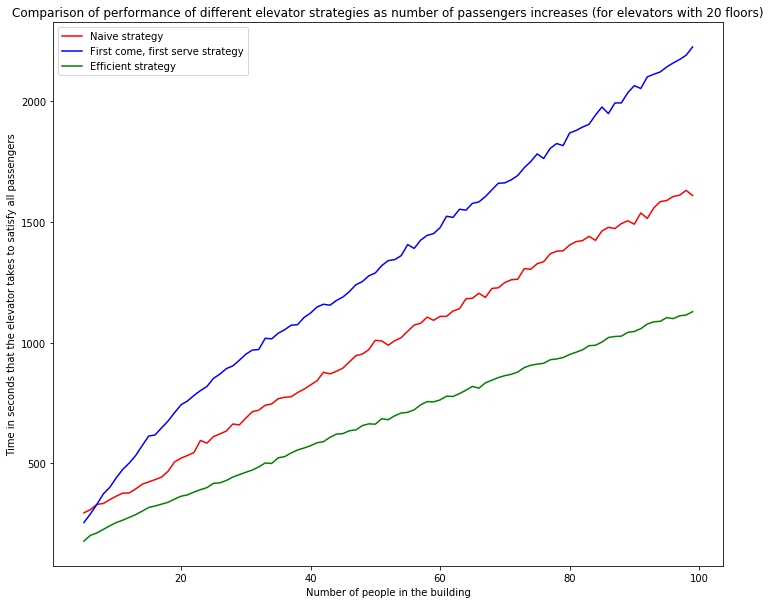

In [11]:
#plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(list(range(5,100)),means_naive,color ='red',label = 'Naive strategy')
plt.plot(list(range(5,100)),means_fcfs,color ='blue', label = 'First come, first serve strategy')
plt.plot(list(range(5,100)),means_efficient,color ='green', label ='Efficient strategy')
plt.xlabel('Number of people in the building')
plt.ylabel('Time in seconds that the elevator takes to satisfy all passengers')
plt.title('Comparison of performance of different elevator strategies as number of passengers increases (for elevators with 20 floors)')
plt.legend()
plt.show()